## 03- Entrenamiento del Modelo

En este notebook realizaremos los procedimientos necesarios para entrenar el modelo que permita establecer la probabilidad de que un cliente no renueve su producto con la compañía, basado en las diferentes dimensiones de información que se tengan del mismo al momento de emitir la póliza y que hemos explorado en los notebooks anteriores. Para ello usaremos las ventajas de la librería `scikit-learn`.

In [1]:
from model_parameters import *
import pandas as pd
import numpy as np
from utils import metrics,get_confusion_plot
from sklearn.metrics import roc_auc_score
data=pd.read_csv("data_modelacion.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns=['NumeroPoliza__c'])

## Revisar Balanceo de Datos

Como podemos observar, la proporción de clientes que no renovaron su poliza son mayores respecto a los que si lo hicieron. Este desbalanceo en la data toma importancia al momento de analizar las métricas de un modelo. Por tanto, es vital utilizar métricas que no sean sensibles al desbalanceo de clases en la información de entrenamiento. Para ello existen además, algunas técnicas como disminuir la información de la clase mayoritaria (undersampling) o incluso generar instancias de la clase minoritaria a partir de algoritmos que utilizan K-nearest neighbors (ver [Adasyn](http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_adasyn.html) o [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html))

In [2]:
data.churn.value_counts(normalize=True)*100

1    52.760664
0    47.239336
Name: churn, dtype: float64

## Generar Particiones de Datos

Se debe generar una partición de la data para test(10%), el restante se usará para entrenamiento y validación.

In [7]:
#Definir esquema para valores faltantes
num_cols=[i for i in data.columns.values.tolist() if data[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c','tipo_ramo_name']]
str_cols=[i for i in data.columns.values.tolist() if data[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','tipo_ramo_name','Tipo_poliza_c']]
train,test=train_test_split(data, test_size=0.10,random_state=666)

In [10]:
##guardar train y test para reproducibilidad
train.to_csv("train.csv",sep=";",index=False)
test.to_csv("test.csv",sep=";",index=False)

## Modelos a Evaluar

Se procede a evaluar dos tipos de modelos de tipo boosting (XGboost,LightGBM), los cuales son ampliamente usados en el modelamiento predictivo. A su vez, se prueba un modelo sencillo como la regresión logística, para comparar el desempeño frente a modelos de mayor complejidad. El objetivo general de esta comparación es establecer qué tipo de modelo puede encontrar los aspectos más relevantes para establecer cuándo un cliente tiene mayor propensión a renovar su producto con la compañía.

In [11]:
from sklearn import set_config
set_config(display='diagram')

In [12]:
# La variable punto de venta tiene más de 1300 categorías, por lo tanto, al tener la ciudad de venta recategorizada, se procede a generar la base de entrenamiento de esta en lugar del punto de venta.
X_train,Y_train=train.drop(columns=["churn","Asegurado__c","PuntoVenta__c"]),train['churn'].values

In [14]:
## Pasos de imputación y estandarización

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer


def get_classifier_model(model_name:str,k_cv:int=5,scoring="f1",imputer="zero",scaler_method="standard",one_hot_str=True,pca=True) -> GridSearchCV:
    """retorna un objeto GridSearchCV para entrenar con @param model_name y k_cv-fold Cross Validation
    para clasificación binaria, la métrica de scoring de los modelos está dada por @param scoring
    @param imputer: str | "zero" usa como enfoque de imputación poner 0 a los valores perdidos, otro valor usa el enfoque de asignar la mediana.
    @param scaler_method: str | "standard" define StandardScaler para escalar variables numéricas, minmax lo define como MinMaxScaler, None no imputa los valores
    @param enable_str_tf: Boolean | True activa one-hot-encoding para las variables categóricas
    """

    scl=StandardScaler() if scaler_method=="standard" else MinMaxScaler()

    if imputer=="zero":
        imp=SimpleImputer(strategy="constant",fill_value=0)
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        ) 
    elif imputer=="median":
        imp=SimpleImputer(strategy="median")
        num_transformer = Pipeline(
        steps=[("imputer", imp), ("scaler",scl)]
        )
    else:
        num_transformer = Pipeline(
        steps=[("scaler",scl)]
        )

    if one_hot_str:
        cat_transformer = OneHotEncoder(handle_unknown="ignore")
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", SimpleImputer(strategy="constant",fill_value="otros"), str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer,  num_cols), ## excluir las variables tipo objeto y dejar las numéricas
            ("cat", cat_transformer, str_cols),  ##incluir solo las variables tipo objeto
        ],sparse_threshold=0
    )

    model=MODEL_LIST[model_name]
    

    param_grid=MODEL_PARAMS[model_name]['param_grid'].copy()
    if pca:
        pipe=Pipeline([
            ('cleaner',preprocessor),
            ('pca',PCA()),
            ('model',model)],verbose=True)
    else:
        pipe=Pipeline([
        ('cleaner',preprocessor),
        ('model',model)], verbose=True)
        param_grid.pop("pca__n_components")
    

    grid=GridSearchCV(pipe,param_grid,cv=k_cv,refit=True,scoring=scoring,verbose=True,n_jobs=-1)
    return grid

xgb=get_classifier_model("xgboost")
logistic=get_classifier_model("logistic_regression")
lightgbm=get_classifier_model("lightgbm")

In [15]:
xgb.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   2.9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [16]:
logistic.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   1.7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_ramo_name',
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [17]:
lightgbm.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

## Verificar desempeño de los modelos

A continuación se proponen métricas generales para evaluar el desempeño de los modelos entrenados para las bases de entrenamiento y test.

In [18]:
#diccionario que almacena métricas de evaluación
results={}

In [19]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_pca']={'train':metrics(Y_train.ravel(),xgb.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_pca']={'train':metrics(Y_train.ravel(),logistic.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),logistic.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_pca']={'train':metrics(Y_train.ravel(),lightgbm.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7387 
 Precision: 0.6919 
 Recall: 0.9091 
 Kappa: 0.4661 
 F1-Score: 0.7858 
ROC-AUC: 0.8673


	 Test 

 Accuracy:0.6730 
 Precision: 0.6468 
 Recall: 0.8460 
 Kappa: 0.3299 
 F1-Score: 0.7331 
ROC-AUC: 0.7593


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6435 
 Precision: 0.6920 
 Recall: 0.5835 
 Kappa: 0.2913 
 F1-Score: 0.6332 
ROC-AUC: 0.7310


	 Test 

 Accuracy:0.6528 
 Precision: 0.7135 
 Recall: 0.5781 
 Kappa: 0.3116 
 F1-Score: 0.6387 
ROC-AUC: 0.7486


===Métricas para LightGBM===


	 Training

 Accuracy:0.8185 
 Precision: 0.7892 
 Recall: 0.8946 
 Kappa: 0.6330 
 F1-Score: 0.8386 
ROC-AUC: 0.9193


	 Test 

 Accuracy:0.6848 
 Precision: 0.6784 
 Recall: 0.7723 
 Kappa: 0.3615 
 F1-Score: 0.7223 
ROC-AUC: 0.7597



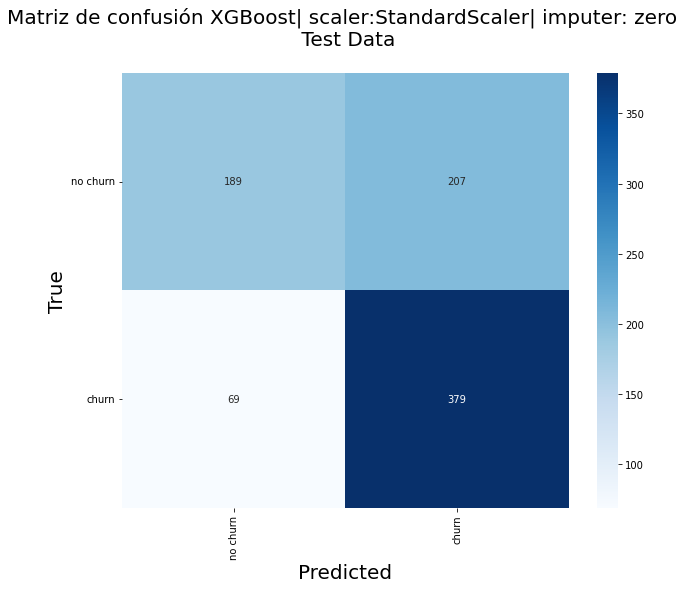

In [42]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),xgb.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGBoost| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Otros enfoques de entrenamiento

Debido a la gran variedad de modelos y de técnicas para intentar maximizar el desempeño de los mismos, es necesario explorarlas. Dependiendo del enfoque, tiempo disponible u otros factores, se pueden abordar más modelos o modificaciones de los modelos evaluados y comparar los resultados. A continuación intentamos evaluar el desempeño, usando otras técnicas de imputación de datos y enfoque para el escalado de variables numéricas. A su vez, analizamos el desempeño de los modelos al eliminar la reducción de dimensionalidad propuesta a través de Componentes Principales(PCA).


In [21]:
#Modelos con escalado minmax e imputación a través de la mediana
xgb_2=get_classifier_model("xgboost",scaler_method="minmax",imputer="median")
logistic_2=get_classifier_model("logistic_regression",scaler_method="minmax",imputer="median")
lightgbm_2=get_classifier_model("lightgbm",scaler_method="minmax",imputer="median")

In [22]:
xgb_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [23]:
logistic_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_ramo_name',
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('pca', PCA()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet'],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [24]:
lightgbm_2.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'OtrosIngresos__c',
                                                                          'Egr...
                                       ('pca', PCA()),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1],
                         'pca__n_components': [10, 20]},
             scoring='f1', verbose=True)

In [25]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_median_minmax_pca']={'train':metrics(Y_train.ravel(),xgb_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),xgb_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_median_minmax_pca']={'train':metrics(Y_train.ravel(),logistic_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),logistic_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_median_minmax_pca']={'train':metrics(Y_train.ravel(),lightgbm_2.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_2.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_median_minmax_pca']['test']=metrics(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_2.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.6393 
 Precision: 0.6068 
 Recall: 0.8974 
 Kappa: 0.2559 
 F1-Score: 0.7240 
ROC-AUC: 0.7125


	 Test 

 Accuracy:0.6303 
 Precision: 0.6037 
 Recall: 0.8839 
 Kappa: 0.2345 
 F1-Score: 0.7174 
ROC-AUC: 0.7090


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6274 
 Precision: 0.6165 
 Recall: 0.7760 
 Kappa: 0.2413 
 F1-Score: 0.6872 
ROC-AUC: 0.6578


	 Test 

 Accuracy:0.6386 
 Precision: 0.6261 
 Recall: 0.7924 
 Kappa: 0.2616 
 F1-Score: 0.6995 
ROC-AUC: 0.6662


===Métricas para LightGBM===


	 Training

 Accuracy:0.7753 
 Precision: 0.7289 
 Recall: 0.9136 
 Kappa: 0.5425 
 F1-Score: 0.8109 
ROC-AUC: 0.8535


	 Test 

 Accuracy:0.6457 
 Precision: 0.6323 
 Recall: 0.7946 
 Kappa: 0.2766 
 F1-Score: 0.7043 
ROC-AUC: 0.6916



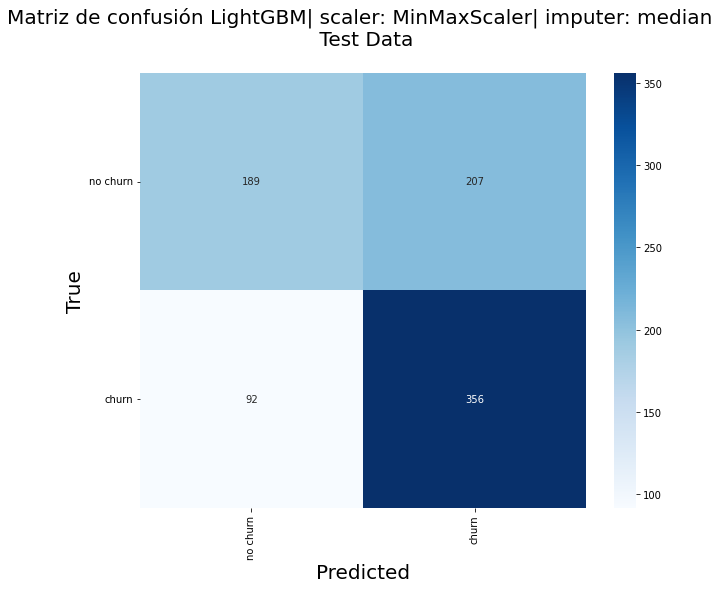

In [40]:
get_confusion_plot(test['churn'].values.ravel(),lightgbm_2.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión LightGBM| scaler: MinMaxScaler| imputer: median \n Test Data\n")

### Analisis del Performance sin Componentes Principales

In [27]:
xgb_nopca=get_classifier_model("xgboost",pca=False)
logistic_nopca=get_classifier_model("logistic_regression",pca=False)
lightgbm_nopca=get_classifier_model("lightgbm",pca=False)

In [28]:
xgb_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_ramo_name',
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01],
                         'model__max_depth': [5, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100, 250],
                         'model__subsample': [0.9, 1]},
             scoring='f1', verbose=True)

In [29]:
logistic_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'edad']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_ramo_name',
                                                                          'tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet']},
             scoring='f1', verbose=True)

In [30]:
lightgbm_nopca.fit(X_train,Y_train.ravel())

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[Pipeline] ........... (step 1 of 2) Processing cleaner, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9],
                         'model__max_depth': [10, 15],
                         'model__n_estimators': [100, 150, 500],
                         'model__num_leaves': [10, 50],
                         'model__reg_alpha': [0.0, 1.1, 1.2],
                         'model__reg_lambda': [0.0, 1.1, 1.2],
                         'model__subsample': [0.9, 1]},
             scoring='f1', verbose=True)

In [31]:
print("===Métricas para XGboost===\n")
print("\n\t Training\n")
results['xgb_zero_std_nopca']={'train':metrics(Y_train.ravel(),xgb_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),xgb_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['xgb_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),xgb_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),xgb_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para Regresión Logística===\n")
print("\n\t Training\n")
results['logistic_zero_std_nopca']={'train':metrics(Y_train.ravel(),logistic_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),logistic_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['logistic_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),logistic_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),logistic_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n===Métricas para LightGBM===\n")
print("\n\t Training\n")
results['lightgbm_zero_std_nopca']={'train':metrics(Y_train.ravel(),lightgbm_nopca.predict(X_train))}
roc=roc_auc_score(Y_train.ravel(),lightgbm_nopca.predict_proba(X_train)[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))
print("\n\t Test \n")
results['lightgbm_zero_std_nopca']['test']=metrics(test['churn'].values.ravel(),lightgbm_nopca.predict(test.drop(columns=["churn","Asegurado__c"])))
roc=roc_auc_score(test['churn'].values.ravel(),lightgbm_nopca.predict_proba(test.drop(columns=["churn","Asegurado__c"]))[:,1])
print("ROC-AUC: {:.4f}\n".format(roc))

===Métricas para XGboost===


	 Training

 Accuracy:0.7508 
 Precision: 0.7120 
 Recall: 0.8856 
 Kappa: 0.4930 
 F1-Score: 0.7894 
ROC-AUC: 0.8614


	 Test 

 Accuracy:0.6742 
 Precision: 0.6520 
 Recall: 0.8281 
 Kappa: 0.3340 
 F1-Score: 0.7296 
ROC-AUC: 0.7697


===Métricas para Regresión Logística===


	 Training

 Accuracy:0.6473 
 Precision: 0.6952 
 Recall: 0.5895 
 Kappa: 0.2987 
 F1-Score: 0.6380 
ROC-AUC: 0.7330


	 Test 

 Accuracy:0.6611 
 Precision: 0.7225 
 Recall: 0.5871 
 Kappa: 0.3280 
 F1-Score: 0.6478 
ROC-AUC: 0.7510


===Métricas para LightGBM===


	 Training

 Accuracy:0.8715 
 Precision: 0.8387 
 Recall: 0.9363 
 Kappa: 0.7405 
 F1-Score: 0.8849 
ROC-AUC: 0.9636


	 Test 

 Accuracy:0.7038 
 Precision: 0.6996 
 Recall: 0.7746 
 Kappa: 0.4011 
 F1-Score: 0.7352 
ROC-AUC: 0.7845



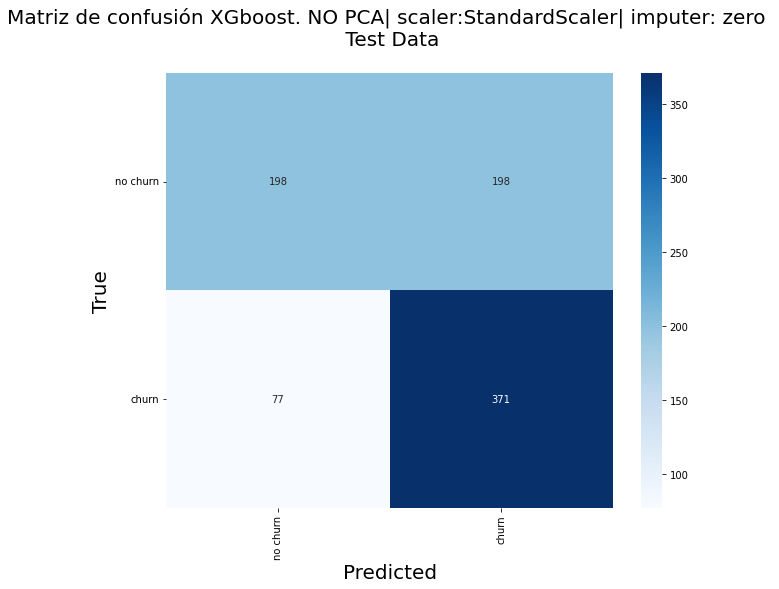

In [32]:
## Matriz de confusión para el mejor modelo de este enfoque
get_confusion_plot(test['churn'].values.ravel(),xgb_nopca.predict(test.drop(columns=["churn","Asegurado__c"])),class_names=['no churn','churn'],title="Matriz de confusión XGboost. NO PCA| scaler:StandardScaler| imputer: zero \n Test Data\n")

## Resumir métricas de desempeño

In [33]:
results_df=pd.DataFrame([(k,k1,v1['kappa'],v1['accuracy'],v1['prec'],v1['f1'],v1['recall']) for k,v in results.items() for k1,v1 in v.items()],columns=['model','etapa','kappa','accuracy','precision','f1','recall'])
results_df=results_df.melt(id_vars=['model','etapa'],value_vars=['kappa','accuracy','precision','f1','recall'],value_name="valor",var_name="Métrica")

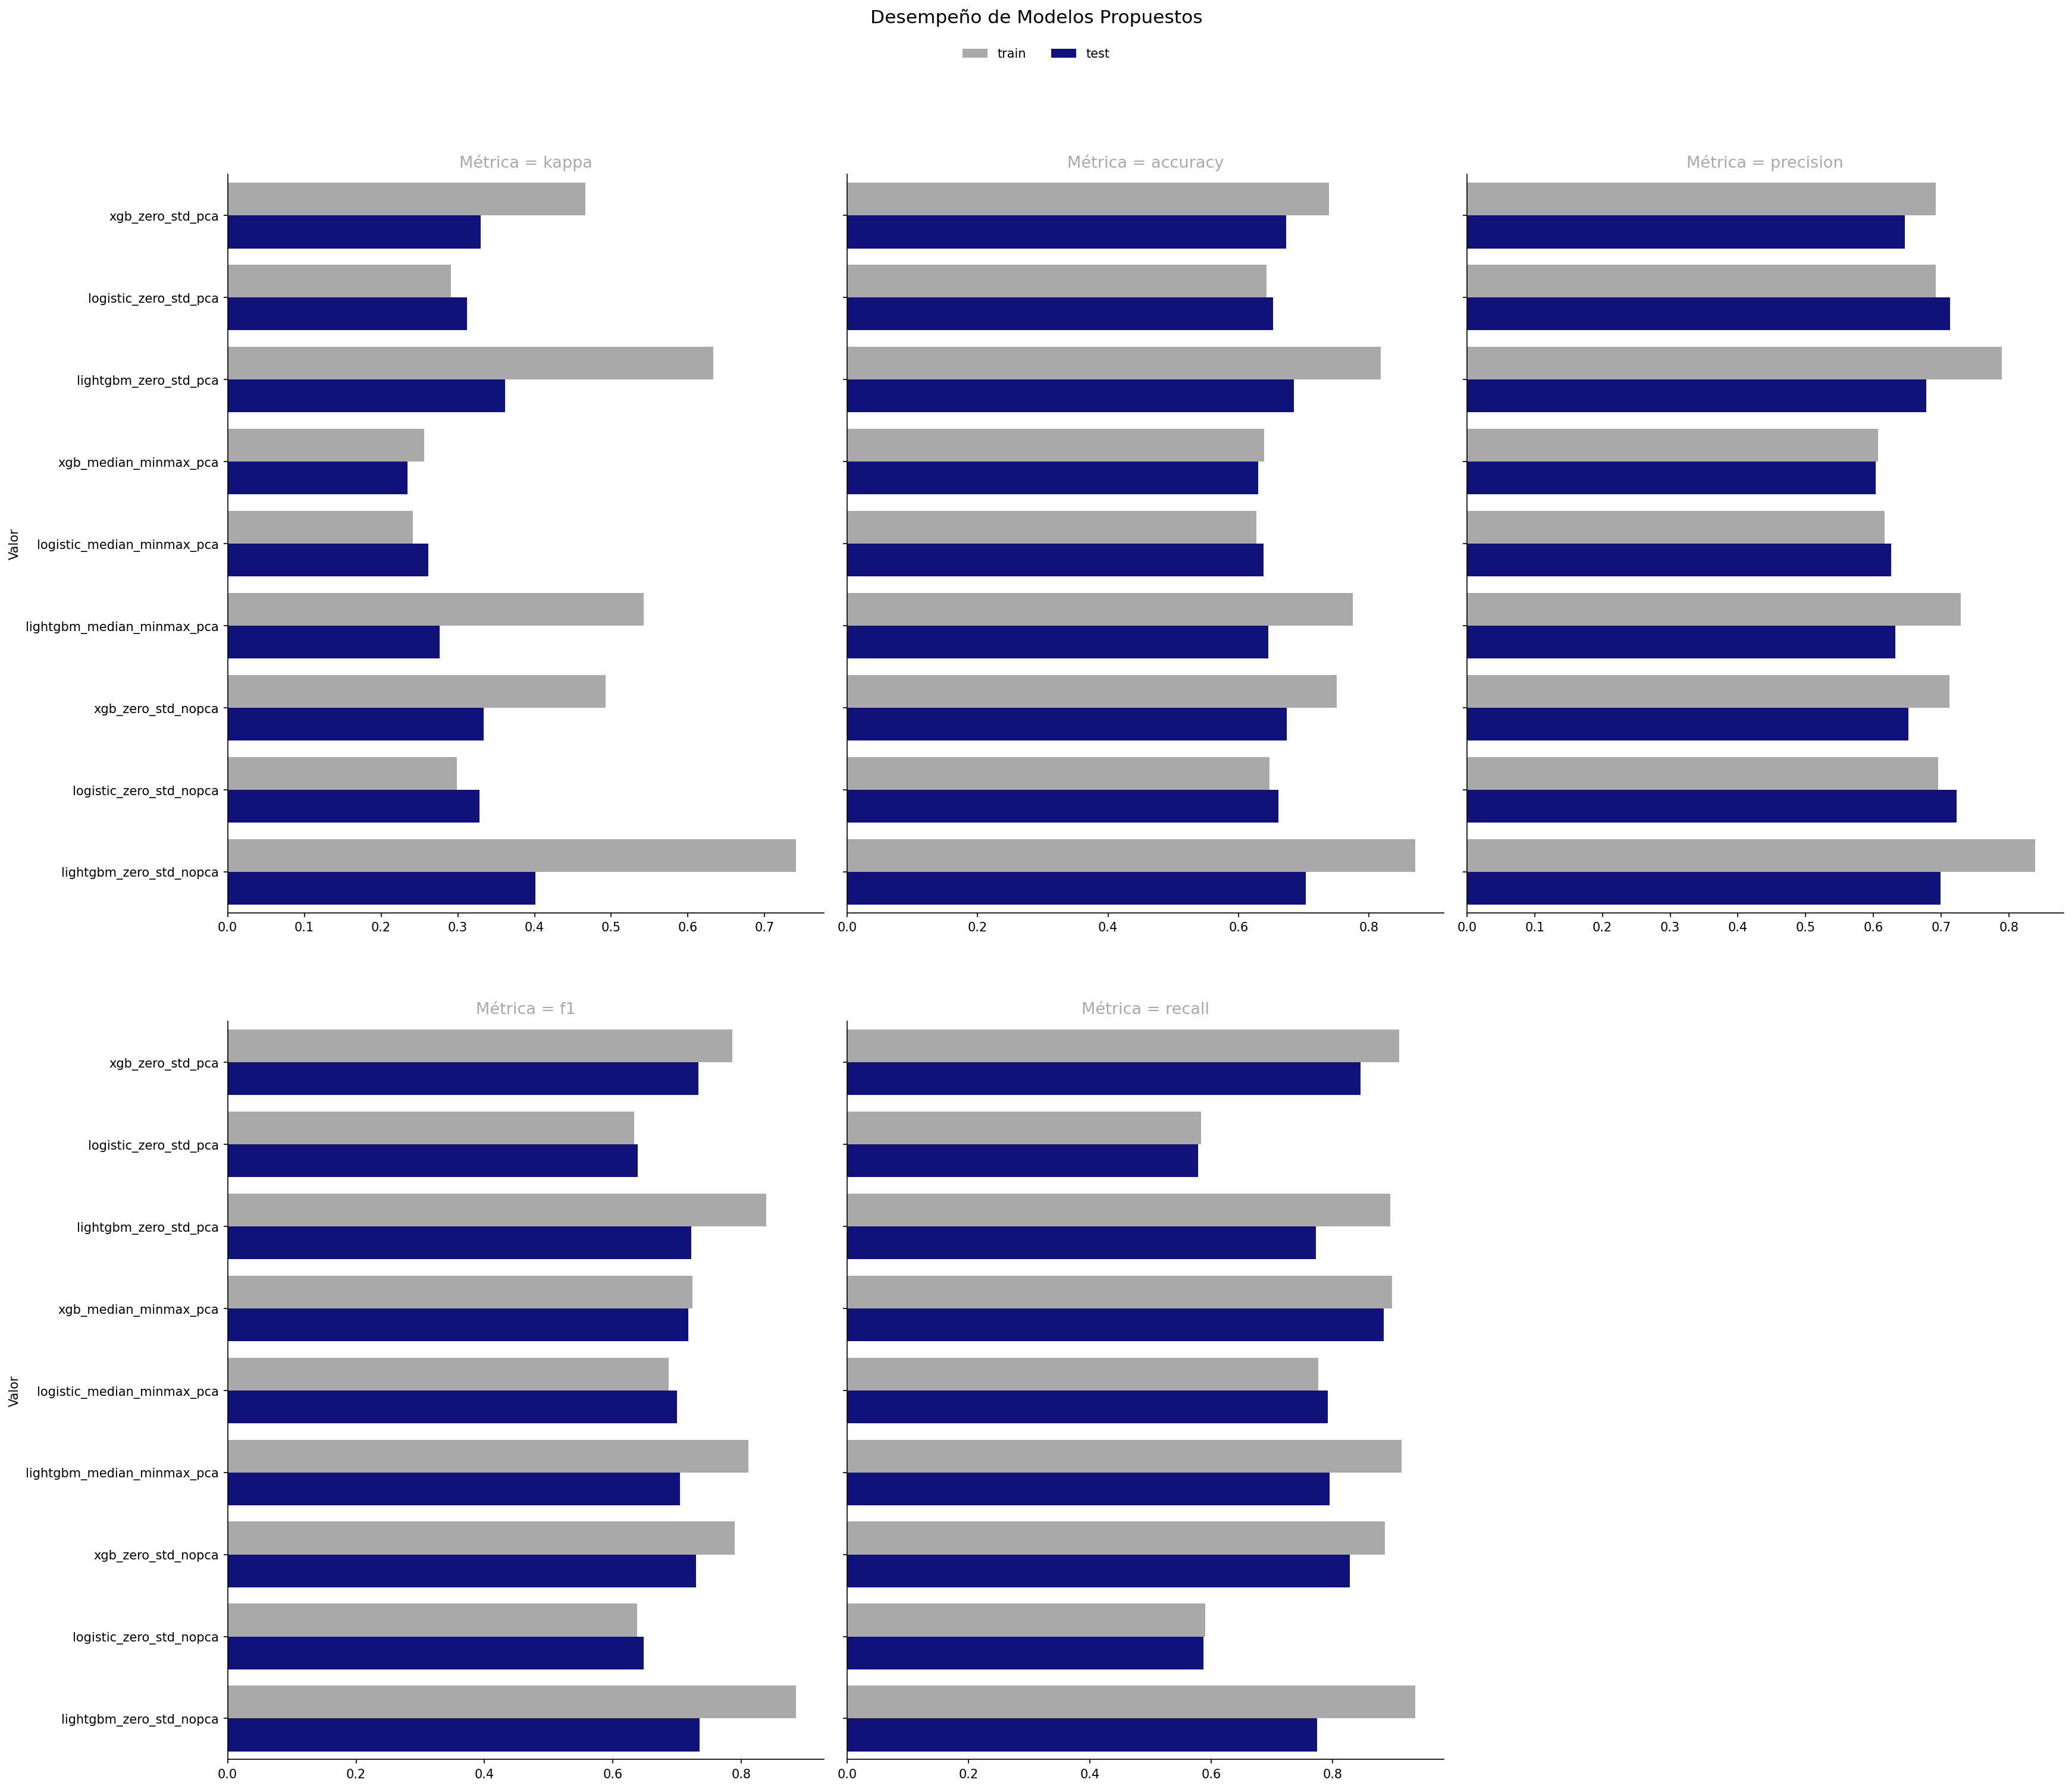

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.catplot(y="model", x="valor", col="Métrica",hue="etapa",kind="bar",legend=True,
                data=results_df,col_wrap=3,sharex=False,aspect=1.5,orient="h",palette={'train':'darkgray','test':'darkblue'})
for i in g.axes:
    i.set_ylabel("Valor")
    i.set_title(i.get_title(),size=13)
    i.title.set_color("darkgray")
    #i.set_xticklabels(i.get_xticklabels(), rotation=90)
    i.set_xlabel("\n")
g.figure.suptitle("Desempeño de Modelos Propuestos", y=1.02,size=15);
g.fig.tight_layout()
g.fig.set_figheight(20)
g.fig.set_dpi(150)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.985),
    ncol=2,
    title=None, frameon=False
)


## Discusión

- La selección del mejor modelo dependerá de las necesidades de negocio. Sin embargo, en cuanto a recall, la regresión logística sin reducción de dimensionalidad(PCA), imputación de ceros en variables numéricas y standardScaler obtuvo el mejor desempeño. Por otro, lado fue la de peor precisión. 

- El modelo más robusto de los propuestos, en términos de precisión, score f1 y kappa fue XGboost (sin reducción de dimensionalidad(PCA), imputación de ceros y standardScaler). Sin embargo, cabe la posibilidad de explorar modelos adicionales o mas hiperparámetros de los modelos propuestos.

- Existen otras posibilidades de exploración en cuanto a encontrar el mejor modelo, y es hacer un análisis con diferentes puntos de corte para la probabilidad. Actualmente para los modelos logísticos, se asume el churn si la probabilidad que arroja el modelo es mayor a 0.5. Sin embargo, este valor puede modificarse para evaluar el comportamiento de las métricas con puntos de corte diferentes.


### Exportar modelos para futuro uso

In [47]:
import pickle
import os

if not os.path.isdir("models"):
    os.mkdir("models")

with open("models/xgbmodel.pickle","wb") as f:
    pickle.dump(xgb,f)

with open("models/logistic.pickle","wb") as f:
    pickle.dump(logistic,f)

with open("models/lightgbm.pickle","wb") as f:
    pickle.dump(lightgbm,f)

In [44]:
with open("models/xgbmodel.pickle","rb") as f:
   xgb= pickle.load(f)

In [4]:
##reutilizar | leer modelos guardados
import pickle
with open("models/logistic_2.pickle", 'rb') as f:
    logistic_2 = pickle.load(f)